## Importing packages

In [ ]:
import pandas as pd
import re
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

### reading csv file cleaning file

In [3]:
file = './data2.csv'
data = pd.read_csv(file)
data.drop('Unnamed: 0',axis=1,inplace=True)

Removing unwanted column.

removing duplicates that may have been scraped as the search words may have overlapped.

In [5]:
#removing duplicates
data.drop_duplicates(subset = 'job_description',inplace=True)

In [6]:
#check to see how much was removed.
data.shape

(826, 12)

Cleaning up the text entries in Job Category, Sub Location and Job Description - removing tags and punctuation

In [7]:
data['job_category'] = data['job_category'].map(lambda x: re.sub('^, ','',x))
data['sub_location'] = data['sub_location'].map(lambda x: re.sub('^, ','',x))

In [8]:
data['job_description'] = data['job_description'].map(lambda x: re.sub('(\\r\\n)+','',x))
data['job_description'] = data['job_description'].map(lambda x: re.sub('(\\xa0)+','',x))

Next checking for null values - we noticed that there is a lot in the salary column.

In [9]:
data.salary.isna().sum()

485

In [10]:
data.job_description.isna().sum()

0

In [11]:
pd.set_option('display.max_colwidth', 15)
data.head(50)

,advertiser,industry,job_category,job_description,job_title,job_type,link,location,posting_date,salary,search_word,sub_location
0,Ambition Te...,Information...,Engineering...,"Our client,...",Senior Data...,Full Time,https://www...,Brisbane,15 May 2019,NaN,data scientist,CBD & Inner...
1,Randstad - ...,Information...,Database De...,The Data En...,Data Engine...,Full Time,https://www...,Brisbane,14 May 2019,$111526 - $...,data scientist,CBD & Inner...
2,PRA,Information...,Consultants,Brisbane CB...,Data Engineer,Full Time,https://www...,Brisbane,11 May 2019,NaN,data scientist,CBD & Inner...
3,Synergy Pla...,Information...,Developers/...,Contract r...,Data Engine...,Contract/Temp,https://www...,Brisbane,7 May 2019,NaN,data scientist,CBD & Inner...
4,GRIT Talent...,Information...,Database De...,We are seek...,Data Engineer,Contract/Temp,https://www...,Brisbane,3 May 2019,$100 - $120...,data scientist,Database De...
5,Luminoso Re...,Information...,Database De...,The client:...,Data Engine...,Contract/Temp,https://www...,Brisbane,3 May 2019,NaN,data scientist,CBD & Inner...
6,Osborne Ric...,Engineering,Civil/Struc...,Osborne Ric...,Asset Data ...,Contract/Temp,https://www...,Brisbane,15 May 2019,$64 plus su...,data scientist,Southern Su...
7,Just Digita...,Information...,Engineering...,This role i...,Data Engine...,Full Time,https://www...,Brisbane,29 Apr 2019,NaN,data scientist,Engineering...
8,Fugro Austr...,Information...,Engineering...,About Fugro...,Data Engineer,Full Time,https://www...,Brisbane,10 May 2019,NaN,data scientist,CBD & Inner...
9,Servian,Information...,Consultants,We are look...,Consultant ...,Full Time,https://www...,Brisbane,29 Apr 2019,NaN,data scientist,CBD & Inner...


We removed a number of columns so resetting index.

In [12]:
data = data.reset_index(drop=True)

Lastly, ude to the way we scrapped, it seems like there were instances of sub_location not being entered and hence the job category info was scrapped instead. As such we are blanking these out where we find the two fields are identical.

In [13]:
for i in range(1,len(data.sub_location)):
    if data.sub_location[i] == data.job_category[i]:
        data.sub_location[i] = ''

## Cleaning Salary Column

### Writing up all the functions that will be used for cleaning the columns

In [14]:
#extracting only entries with numbers but removes phone numbers
def find_number(x):
    if type(x) == str:
        if "phone" in x.lower() or "call" in x.lower() or "hours" in x.lower() or "weeks" in x.lower():
            return
        else:
            if type(re.search(".*\\d.*",str(x))) == re.Match:
                return x.replace('−',' − ').replace('-',' - ').replace(',','').replace(' K ','000').replace('K','000').replace('k','000').replace('+',' + ').replace('.00','')
            else:
                return
    else:
        return

# find the min salary figure
def give_min_max(x):
    if type(x) == str:

        remove_list = re.findall('\d+\.?\d?\d?\%', x)
        results = re.findall('\d+\.?0?0?', x) 
        
        remove_list2=[]
        for unwanted in remove_list:
            unwanted_ = re.findall('\d+\.?0?0?', unwanted)
            remove_list2 += unwanted_
        for fin_unwanted in remove_list2:    
            results.remove(fin_unwanted)
        for result in results:
            if result == "000":
                results.remove('000')
                break
        if len(results) == 1:
            return results[0]
        elif len(results) == 0:
            return
        else:
            if len(results[1]) - len(results[0]) > 2:
                return results[0]+'000'
            else:
                return results[0]
    else:
        return
    
period =['p.h', 'p.d', 'p.w', 'p.f', 'p.m', 'p.a',
         'ph', 'pd', 'pw', 'pf', 'pm', 'pa',
         'p/h', 'p/d', 'p/w', 'p/f', 'p/m', 'p/a', 
         'hour', 'day', 'week', 'fortnight', 'month', 'annum', 'annual', 'year']

#find the period quoted for salary
def find_period(string):
    token = nltk.word_tokenize(str(string))
    results = ['']
    for n in token:
        if n in period:
            results[0]=convert_period(str(n))
    return results[0]

# reducing nunique in period
def convert_period(string):
    if string == 'ph' or string == 'hour' or string == 'p/h' or string == 'p.h':
        return 2080
    elif string == 'pd' or string == 'day' or string == 'p/d' or string == 'p.d':
        return 260
    elif string == 'pw' or string == 'week' or string == 'p/w' or string == 'p.w':
        return 52
    elif string == 'pf' or string == 'fortnight' or string == 'p/f' or string == 'p.f':
        return 26
    elif string == 'pm' or string == 'month' or string == 'p/m' or string == 'p.m':
        return 12
    elif string == 'pa' or string == 'annual' or string == 'p/a' or string == 'p.a':
        return 1
    elif string == 'year':
        return 1

The process to cleaning was step by step creating new columns as we go - We ill remove all the working columns once we are done. The below cells are just applying the above functions, extracting the numeric salary values from the salary columns.

In [15]:
data['salary_numeric'] = data['salary'].apply(find_number)
data['salary_min'] = data['salary_numeric'].apply(give_min_max)
data['period'] = data['salary_numeric'].apply(find_period)

We also need to extract salary from the title and description columns. Here we will again create 2 new columns as I do not want to override what we previously got from the salary.

In [16]:
def extract_sal(x):
    if type(x) == str:
        x_clean = x.replace('−',' − ').replace('-',' - ').replace(',','').replace('k','000').replace('+',' + ')
        extracted_sal = re.findall("\$\d+",x_clean) + re.findall("\d+k",x_clean)
        for value in extracted_sal:
            clean_value = value.replace('$','').replace('K','000')
            if len(clean_value) == 5 or len(clean_value) == 6:
                if float(clean_value) < 300000:
                    return clean_value

In [17]:
data['salary_from_title'] = data.job_title.apply(extract_sal)
data['salary_from_descript'] = data.job_description.apply(extract_sal)

Converting the extracted salaries to float so we can compare the values.

In [18]:
data['salary_min'] = data['salary_min'].apply(lambda x: float(x or 0.00))
data['salary_from_title'] = data['salary_from_title'].apply(lambda x: float(x or 0.00))
data['salary_from_descript'] = data['salary_from_descript'].apply(lambda x: float(x or 0.00))
data['period'] = data['period'].apply(lambda x: float(x or 0.00))
# data[data['salary_min']>150000].salary_min

In [19]:
# pd.set_option('display.max_colwidth', -1)
# data.loc[7550].salary_min = 75000
# data[data['salary_from_descript']=='100000']

As there may be other numbers aside from salary extracted (such as super of 9%), the below serves to extract the actual salary figures by impossing specific conditions on it. At the same time, I convert the salaries to annual where possible in the last for loop.

In [20]:
min_sal = data.salary_min.values.tolist()
sal_title = data.salary_from_title.values.tolist() 
sal_descript = data.salary_from_descript.values.tolist()
sal_period = data.period.values.tolist()

for i in range(0,len(min_sal)):
    if sal_title[i] != 0 and min_sal[i] == 0:
        min_sal[i] = sal_title[i+1]
for i in range(0,len(min_sal)):
    if sal_descript[i] != 0 and min_sal[i] == 0:
        min_sal[i] = sal_descript[i]

for i in range(0,len(min_sal)):
    if sal_period[i] == 0:
        if min_sal[i] < 100:
            min_sal[i] = min_sal[i]*2080
        elif min_sal[i] < 1000:
            min_sal[i] = min_sal[i]*260
    elif sal_period[i] > 0.0:
        min_sal[i] = min_sal[i]* sal_period[i]

In [21]:
data['salary_cleaned'] = min_sal

Here, I check and see if I am coming up with unreasonable values. I have the choice of manually editing the remainder or simply removing them. I end up manually looking at and editing these values given my small data set. I do this by going back to the job links and understanding if there is an actual value. If there is not, then I would remove the data entry.

In [22]:
data[(data['salary_cleaned'] > 0) & (data['salary_cleaned'] < 30000)]

,advertiser,industry,job_category,job_description,job_title,job_type,link,location,posting_date,salary,search_word,sub_location,salary_numeric,salary_min,period,salary_from_title,salary_from_descript,salary_cleaned
29,Correlate R...,Information...,Database De...,In this exc...,Senior Data...,Contract/Temp,https://www...,Melbourne,15 May 2019,up to $1200pd,data scientist,CBD & Inner...,up to $1200pd,1200.0,0.0,0.0,0.0,1200.0
128,Bluefin Res...,Marketing &...,Market Rese...,Working wit...,Marketing A...,Full Time,https://www...,Sydney,14 May 2019,$550 - $650...,data analyst,North West ...,$550 - $6...,550.0,1.0,0.0,0.0,550.0
299,FIRESOFT Co...,Information...,Business/Sy...,Senior Data...,Senior Data...,Full Time,https://www...,Sydney,13 May 2019,$1k - $160k...,research sc...,"CBD, Inner ...",$1000 - $...,1000.0,1.0,0.0,0.0,1000.0
321,AYAN INFOTE...,Information...,Networks & ...,Ayan Infot...,Palo Alto C...,Contract/Temp,https://www...,Sydney,8 May 2019,3,research sc...,,3,3.0,0.0,0.0,0.0,6240.0
503,Victoria Un...,Education &...,Other,15 Project-...,Project Bas...,Full Time,https://www...,Melbourne,1 May 2019,NaN,research sc...,CBD & Inner...,None,0.0,0.0,0.0,27600.0,27600.0
513,Saltworth® ...,Information...,Developers/...,We're looki...,Python / PH...,Full Time,https://www...,Melbourne,3 May 2019,long-term 6...,research sc...,CBD & Inner...,long - term...,6000.0,0.0,0.0,0.0,6000.0
607,TRS - IT & ...,Information...,Testing & Q...,A unique r...,Test Analys...,Full Time,https://www...,Sydney,29 Apr 2019,3 Month Con...,business in...,"CBD, Inner ...",3 Month Con...,3.0,260.0,0.0,0.0,780.0
661,Finite IT R...,Information...,Team Leaders,SAP S4HANA ...,SAP S4HANA ...,Contract/Temp,https://www...,Sydney,30 Apr 2019,Paying up t...,business in...,,Paying up t...,1450.0,0.0,0.0,0.0,1450.0
764,T+O+M Execu...,Banking & F...,Banking - R...,I’m very ex...,(Big) Data ...,Full Time,https://www...,Sydney,15 May 2019,$130.000 - ...,business in...,,$1300 - $...,1300.0,0.0,0.0,0.0,1300.0


In [23]:
data.loc[29].link

'https://www.seek.com.au/job/39029403?type=standout&searchrequesttoken=8e13f688-b706-4142-ad97-86a1055a3912'

In [24]:
data.at[29, 'salary_cleaned'] = 312000.0
data.at[128, 'salary_cleaned'] = 143000.0
data.at[299, 'salary_cleaned'] = 150000.0
data.at[321, 'salary_cleaned'] = 0.0
data.at[503, 'salary_cleaned'] = 0.0
data.at[513, 'salary_cleaned'] = 0.0
data.at[607, 'salary_cleaned'] = 156000.0
data.at[661, 'salary_cleaned'] = 364000.0
data.at[764, 'salary_cleaned'] = 0.0


Having gotten may salaries, just doing a quick plot to see what the distribution of salary looks like.

C:\Users\Roy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


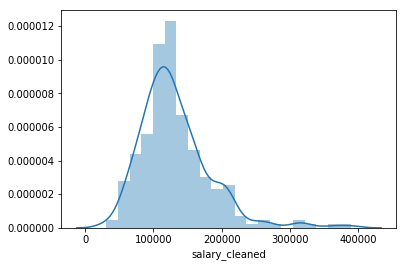

In [25]:
data_w_sal = data[data['salary_cleaned']!=0]
sns.distplot(data_w_sal.salary_cleaned)

## Categorising Job Titles

In [26]:
data.job_title.value_counts()

Data Analyst                                                                        58
Data Scientist                                                                      32
Data Engineer                                                                       23
Senior Data Analyst                                                                 16
Senior Data Scientist                                                               14
Big Data Engineer                                                                    9
Senior Data Engineer                                                                 6
Business Intelligence Lead                                                           6
Business Intelligence Developer                                                      5
Data Analyst                                                                         5
Software Engineer                                                                    5
BI Developer                               

Selecting keywords in the titles I believe would indicate a specific job category.

In [27]:
data_analyst_key = ['data analyst','data analytics', 'insights', 'sap', 'fullstack','full-stack',
                    'full stack', 'quantitative', 'reporting','risk analyst','data anayst','recruitment analyst',
                   'marketing analyst','actuary','actuarial']
data_scientist_key = ['data scientist','data science','machine learning','modelling']
data_engineer_key = ['engineer','big data', 'etl', 'gis','wrangler','wrangling']
business_intel_key = ['bi','business intelligence','intelligency','intellegience']
academic_key = ['research','postdoctoral']

senior_key = ['senior', 'head', 'lead', 'manager']
junior_key = ['junior']

In [28]:
data[data['job_title']=="Data Analyst"]

,advertiser,industry,job_category,job_description,job_title,job_type,link,location,posting_date,salary,search_word,sub_location,salary_numeric,salary_min,period,salary_from_title,salary_from_descript,salary_cleaned
62,Continuum R...,Information...,Business/Sy...,Data Analys...,Data Analyst,Contract/Temp,https://www...,Sydney,13 May 2019,NaN,data analyst,,None,0.0,0.0,0.0,0.0,0.0
63,Hydrogen Gr...,Information...,Database De...,ClientOur c...,Data Analyst,Contract/Temp,https://www...,Sydney,16 May 2019,Competitive...,data analyst,"CBD, Inner ...",None,0.0,0.0,0.0,0.0,0.0
65,Hays Inform...,Information...,Architects,Permanent D...,Data Analyst,Full Time,https://www...,Sydney,15 May 2019,NaN,data analyst,"CBD, Inner ...",None,0.0,0.0,0.0,0.0,0.0
67,Randstad - ...,Information...,Other,Salesforce ...,Data Analyst,Contract/Temp,https://www...,Sydney,14 May 2019,NaN,data analyst,,None,0.0,0.0,0.0,0.0,0.0
68,Salient Group,Information...,Business/Sy...,Who are we:...,Data Analyst,Full Time,https://www...,Sydney,16 May 2019,"$75,000 - $...",data analyst,North Shore...,$75000 - ...,75000.0,0.0,0.0,0.0,75000.0
69,Talent – Wi...,Information...,Business/Sy...,NSW Governm...,Data Analyst,Contract/Temp,https://www...,Sydney,14 May 2019,$550 - $600...,data analyst,"CBD, Inner ...",$550 - $6...,550.0,260.0,0.0,0.0,143000.0
77,Kelly Gover...,Government ...,Government ...,6 Month Con...,Data Analyst,Contract/Temp,https://www...,Sydney,13 May 2019,$50 - $57.5...,data analyst,"CBD, Inner ...",$50 - $57...,50.0,2080.0,0.0,0.0,104000.0
82,Sydney Trains,Government ...,Government ...,BURWOODPerm...,Data Analyst,Full Time,https://www...,Sydney,10 May 2019,NaN,data analyst,Parramatta ...,None,0.0,0.0,0.0,103547.0,103547.0
83,Talent – Wi...,Information...,Business/Sy...,Data Analys...,Data Analyst,Contract/Temp,https://www...,Sydney,8 May 2019,Competitive,data analyst,Parramatta ...,None,0.0,0.0,0.0,0.0,0.0
88,Ford Peterson,Banking & F...,Analysis & ...,About the C...,Data Analyst,Full Time,https://www...,Sydney,10 May 2019,NaN,data analyst,"CBD, Inner ...",None,0.0,0.0,0.0,0.0,0.0


Originally I also looked to split between Junior/Senior and normal but given the low number of junior jobs, I have removed this category. The below code simply makes use the the above list to determine the new categories.

In [29]:
# need to remove punctuation 
def senior_junior(x,job2):
    for n in senior_key:
        if type(re.search(n,job2)) == re.Match:
            return 'seinor ' + x
#     for n in junior_key:
#         if type(re.search(n,job2)) == re.Match:
#             return 'junior ' + x    
    return x

def title_def(row):
    job = row.lower()
    job2 = re.sub(r'[^\w\s]','',job)

    for n in data_analyst_key:
        if type(re.search(n,job2)) == re.Match:
            return senior_junior('data analyst',job2)
    for n in data_scientist_key:
        if type(re.search(n,job2)) == re.Match:
            return senior_junior('data scientist',job2)
    for n in data_engineer_key:
        if type(re.search(n,job2)) == re.Match:
            return senior_junior('data engineer',job2)
    for n in business_intel_key:
        if type(re.search(n,job2)) == re.Match:
            return senior_junior('business intelligence',job2)
    for n in academic_key:
        if type(re.search(n,job2)) == re.Match:
            return senior_junior('academic', job2)
    return 'undefined jobs'

In [30]:
data['job_categorised'] = data['job_title'].apply(title_def)

In [31]:
data.shape

(826, 19)

In [32]:
data['job_categorised'].value_counts()

data analyst                    206
undefined jobs                  174
data engineer                   118
data scientist                   72
business intelligence            66
seinor business intelligence     59
seinor data analyst              51
seinor data scientist            37
seinor data engineer             34
seinor academic                   5
academic                          4
Name: job_categorised, dtype: int64

A number of jobs were not able to be categorised. Reviewing the titles, alot of them do not seem to be relevant. Hence these entries were ultimately remvoed.

In [33]:
undefined = data[data['job_categorised']=="undefined jobs"]['job_title']

In [34]:
for i in undefined:
    print(i)

Technology and Delivery Manager
Sales & Operations Analyst
Data/Commercial Analyst - 6 Months - Manly
Database Manager - Part time
Analytics Consultant
Senior Policy Adviser
Campaign Analyst
Sales Operations Analyst
Customer Analyst
Manager Business Analytics and System Support
Technical Solution Architect
Senior Product Manager
Analytics Manager - Marketing
Senior Advanced Analytics Consultant 
Fraud Analyst | SAS, SQL, R or Python
2x Innovative Java Developers Wanted (Mid & Senior/Architect) Innovation Team
Hiring Graduate
Product and Project Manager - Analytics
Senior Golang Developer l Sydney CBD l $140K - $170K
ICT Business Analyst
Palo Alto Checkpoint
Senior Analyst, Advanced Analytics Projects (Consulting)
Quant Developer (Modern C++, Python and Java) - Leading Australian Bank
Senior Front End Developer
Developer- Robotics -C, C++
Senior Lead Developer (Contract) - $1000pd
x2 Python Developers (Tech Start Up), Sydney CBD, $125 - $150K base
Applications Architect - Auckland Based

In [35]:
linkage=data[data['job_title']=='Delivery Specialist Financial Crime Detection'].link
for i in linkage:
    print(i)

https://www.seek.com.au/job/38872683?type=standard&searchrequesttoken=35f097d4-145d-4fb7-a64e-1c10e702f088


In [36]:
data = data.drop(data[data['job_categorised']=="undefined jobs"].index)

In [37]:
data.job_categorised.value_counts()

data analyst                    206
data engineer                   118
data scientist                   72
business intelligence            66
seinor business intelligence     59
seinor data analyst              51
seinor data scientist            37
seinor data engineer             34
seinor academic                   5
academic                          4
Name: job_categorised, dtype: int64

## Categorising Industry

Similar to categorising the job categories, we follow the same approach to categorise industries. As the majority of the industry came from the technology industry, we only split our groups into 3. The remaining categories do not have enough values for it to be meaningful.

In [38]:
data.industry.value_counts()

Information & Communication Technology    501
Science & Technology                       32
Banking & Financial Services               21
Consulting & Strategy                      18
Marketing & Communications                 14
Accounting                                 13
Sales                                      12
Government & Defence                       10
Education & Training                        6
Insurance & Superannuation                  6
Engineering                                 6
Administration & Office Support             4
Real Estate & Property                      2
Advertising, Arts & Media                   2
Healthcare & Medical                        2
Retail & Consumer Products                  1
Manufacturing, Transport & Logistics        1
Human Resources & Recruitment               1
Name: industry, dtype: int64

In [39]:
technology = ['Information & Communication Technology','Science & Technology']
finance = ['Banking & Financial Services','Accounting','Insurance & Superannuation','Real Estate & Property']


In [40]:
def industry_def(row):
    if row in technology:
        return 'technology'
    if row in finance:
        return 'finance'
    return 'other'

In [41]:
data['industry_categorised'] = data['industry'].apply(industry_def)

In [42]:
data['industry_categorised'].value_counts()

technology    533
other          77
finance        42
Name: industry_categorised, dtype: int64

In [43]:
data.head()

,advertiser,industry,job_category,job_description,job_title,job_type,link,location,posting_date,salary,search_word,sub_location,salary_numeric,salary_min,period,salary_from_title,salary_from_descript,salary_cleaned,job_categorised,industry_categorised
0,Ambition Te...,Information...,Engineering...,"Our client,...",Senior Data...,Full Time,https://www...,Brisbane,15 May 2019,NaN,data scientist,CBD & Inner...,None,0.0,0.0,0.0,0.0,0.0,seinor data...,technology
1,Randstad - ...,Information...,Database De...,The Data En...,Data Engine...,Full Time,https://www...,Brisbane,14 May 2019,$111526 - $...,data scientist,CBD & Inner...,$111526 - ...,111526.0,1.0,0.0,0.0,111526.0,data engineer,technology
2,PRA,Information...,Consultants,Brisbane CB...,Data Engineer,Full Time,https://www...,Brisbane,11 May 2019,NaN,data scientist,CBD & Inner...,None,0.0,0.0,0.0,0.0,0.0,data engineer,technology
3,Synergy Pla...,Information...,Developers/...,Contract r...,Data Engine...,Contract/Temp,https://www...,Brisbane,7 May 2019,NaN,data scientist,CBD & Inner...,None,0.0,0.0,0.0,0.0,0.0,data engineer,technology
4,GRIT Talent...,Information...,Database De...,We are seek...,Data Engineer,Contract/Temp,https://www...,Brisbane,3 May 2019,$100 - $120...,data scientist,,$100 - $1...,100.0,2080.0,0.0,0.0,208000.0,data engineer,technology


In [44]:
data.job_type.value_counts()

Full Time          426
Contract/Temp      224
Casual/Vacation      2
Name: job_type, dtype: int64

## Imputing Salaries / Missing Values

We are going to be using the categories previously found and categorising them based on location, industry, job category and type, and using the median value to impute missing values.

In [45]:
data[data['salary_cleaned']!=0.0].groupby(['location','industry_categorised','job_categorised','job_type']).salary_cleaned.median()

location   industry_categorised  job_categorised               job_type     
Brisbane   other                 data analyst                  Full Time         82102.0
                                 data engineer                 Contract/Temp    111280.0
                                                               Full Time        180000.0
                                 seinor data scientist         Full Time         84667.0
           technology            business intelligence         Full Time        120000.0
                                 data engineer                 Contract/Temp    208000.0
                                                               Full Time        111526.0
                                 data scientist                Full Time        150000.0
                                 seinor data scientist         Full Time        130000.0
Melbourne  finance               data analyst                  Contract/Temp     67866.0
                                 

## Finding median salary grouped by industry, title, location and job type

In [46]:
data[data['salary_cleaned']==0].salary_cleaned.count()

457

In [47]:
sal_groups = data.groupby(['location','industry_categorised','job_categorised','job_type'])

In [48]:
data = data.reset_index(drop=True)

In [49]:
for i in range(0,len(data.salary_cleaned)): 
    if data['salary_cleaned'][i] == 0.0:
        loc = data['location'][i]
        ind = data['industry_categorised'][i]
        job_cat = data['job_categorised'][i]
        job_typ = data['job_type'][i]
        data.at[i, 'salary_cleaned'] = data[(data['salary_cleaned']!=0.0) & (data['location']==loc) & 
                                         (data['industry_categorised']==ind) & 
                                         (data['job_categorised']==job_cat) & 
                                         (data['job_type']==job_typ)].salary_cleaned.median()
        

In [69]:
data[data['salary_cleaned'].isnull()]

,advertiser,industry,job_category,job_description,job_title,job_type,link,location,posting_date,salary,search_word,sub_location,salary_numeric,salary_min,period,salary_from_title,salary_from_descript,salary_cleaned,job_categorised,industry_categorised
0,Ambition Te...,Information...,Engineering...,"Our client,...",Senior Data...,Full Time,https://www...,Brisbane,15 May 2019,NaN,data scientist,CBD & Inner...,None,0.0,0.0,0.0,0.0,NaN,seinor data...,technology
22,David Jones,Marketing &...,Market Rese...,We are a di...,Data Scientist,Full Time,https://www...,Melbourne,10 May 2019,NaN,data scientist,CBD & Inner...,None,0.0,0.0,0.0,0.0,NaN,data scientist,other
49,Finite IT R...,Information...,Business/Sy...,Multiplerol...,Data Scientist,Contract/Temp,https://www...,Brisbane,13 May 2019,NaN,data scientist,,None,0.0,0.0,0.0,0.0,NaN,data scientist,technology
50,IPA,Science & T...,Environment...,IPA is curr...,Senior Data...,Contract/Temp,https://www...,Brisbane,14 May 2019,NaN,data scientist,,None,0.0,0.0,0.0,0.0,NaN,seinor data...,technology
56,Servian,Information...,Consultants,The opportu...,Senior Cons...,Full Time,https://www...,Brisbane,10 May 2019,NaN,data scientist,CBD & Inner...,None,0.0,0.0,0.0,0.0,NaN,seinor data...,technology
70,Platinum Pa...,Banking & F...,Funds Manag...,About our c...,Senior Data...,Full Time,https://www...,Sydney,15 May 2019,NaN,data analyst,"CBD, Inner ...",None,0.0,0.0,0.0,0.0,NaN,seinor data...,finance
174,LH Global P...,Engineering,Electrical/...,Engineers –...,Engineers -...,Full Time,https://www...,Sydney,9 May 2019,NaN,data analyst,"CBD, Inner ...",None,0.0,0.0,0.0,0.0,NaN,data engineer,other
178,Hays Policy...,Government ...,"Policy, Pla...",Senior Econ...,Senior Econ...,Contract/Temp,https://www...,Sydney,1 May 2019,super,data analyst,"CBD, Inner ...",None,0.0,0.0,0.0,0.0,NaN,seinor acad...,other
181,Robert Walters,Information...,Business/Sy...,The desired...,Senior Data...,Contract/Temp,https://www...,Melbourne,14 May 2019,Attractive ...,data analyst,,None,0.0,0.0,0.0,0.0,NaN,seinor data...,technology
187,Talent – Wi...,Information...,Programme &...,3 Month Ini...,Senior Data...,Casual/Vaca...,https://www...,Melbourne,8 May 2019,NaN,data analyst,CBD & Inner...,None,0.0,0.0,0.0,0.0,NaN,seinor data...,technology


In [81]:
remaining_val = data[data['salary_cleaned'].isnull()].index.tolist()

A few iterations were ran just in case as there may have been some categories that did not have a salary figure resulting in null values still in the column.

In [82]:
for i in remaining_val: 
    loc = data['location'][i]
    ind = data['industry_categorised'][i]
    job_cat = data['job_categorised'][i]
    job_typ = data['job_type'][i]
    data.at[i, 'salary_cleaned'] = data[(data['industry_categorised']==ind) & 
                                     (data['job_categorised']==job_cat)].salary_cleaned.median()

In [83]:
data[data['salary_cleaned'].isnull()]

,advertiser,industry,job_category,job_description,job_title,job_type,link,location,posting_date,salary,search_word,sub_location,salary_numeric,salary_min,period,salary_from_title,salary_from_descript,salary_cleaned,job_categorised,industry_categorised
365,GQR Global ...,Banking & F...,Stockbrokin...,Our client ...,Trading App...,Full Time,https://www...,Sydney,18 Apr 2019,NaN,research sc...,"CBD, Inner ...",None,0.0,0.0,0.0,0.0,NaN,data engineer,finance
388,Lockheed Ma...,Engineering,Other,Lockheed Ma...,Research En...,Full Time,https://www...,Melbourne,16 May 2019,NaN,research sc...,,None,0.0,0.0,0.0,0.0,NaN,seinor data...,other
414,NAB,Information...,Consultants,Work within...,Senior Cons...,Full Time,https://www...,Melbourne,14 May 2019,NaN,research sc...,,None,0.0,0.0,0.0,0.0,NaN,seinor acad...,technology
418,Xpand Group...,Information...,Other,This is an ...,Senior Cons...,Full Time,https://www...,Melbourne,6 May 2019,NaN,research sc...,CBD & Inner...,None,0.0,0.0,0.0,0.0,NaN,seinor acad...,technology
432,Paxus,Information...,Consultants,Our client ...,Data Resear...,Full Time,https://www...,Melbourne,18 Apr 2019,On Experience,research sc...,CBD & Inner...,None,0.0,0.0,0.0,0.0,NaN,seinor acad...,technology
590,T+O+M Execu...,Banking & F...,Banking - R...,I’m very ex...,(Big) Data ...,Full Time,https://www...,Sydney,15 May 2019,$130.000 - ...,business in...,,$1300 - $...,1300.0,0.0,0.0,0.0,NaN,data engineer,finance


In [87]:
remaining_val = data[data['salary_cleaned'].isnull()].index.tolist()

In [88]:
for i in remaining_val: 
    loc = data['location'][i]
    ind = data['industry_categorised'][i]
    job_cat = data['job_categorised'][i]
    job_typ = data['job_type'][i]
    data.at[i, 'salary_cleaned'] = data[(data['job_categorised']==job_cat)].salary_cleaned.median()

In [89]:
data[data['salary_cleaned'].isnull()]

,advertiser,industry,job_category,job_description,job_title,job_type,link,location,posting_date,salary,search_word,sub_location,salary_numeric,salary_min,period,salary_from_title,salary_from_descript,salary_cleaned,job_categorised,industry_categorised


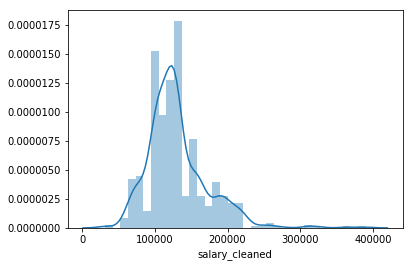

In [90]:
sns.distplot(data['salary_cleaned'])

## Remove working columns

In [91]:
data.head()

,advertiser,industry,job_category,job_description,job_title,job_type,link,location,posting_date,salary,search_word,sub_location,salary_numeric,salary_min,period,salary_from_title,salary_from_descript,salary_cleaned,job_categorised,industry_categorised
0,Ambition Te...,Information...,Engineering...,"Our client,...",Senior Data...,Full Time,https://www...,Brisbane,15 May 2019,NaN,data scientist,CBD & Inner...,None,0.0,0.0,0.0,0.0,120000.0,seinor data...,technology
1,Randstad - ...,Information...,Database De...,The Data En...,Data Engine...,Full Time,https://www...,Brisbane,14 May 2019,$111526 - $...,data scientist,CBD & Inner...,$111526 - ...,111526.0,1.0,0.0,0.0,111526.0,data engineer,technology
2,PRA,Information...,Consultants,Brisbane CB...,Data Engineer,Full Time,https://www...,Brisbane,11 May 2019,NaN,data scientist,CBD & Inner...,None,0.0,0.0,0.0,0.0,111526.0,data engineer,technology
3,Synergy Pla...,Information...,Developers/...,Contract r...,Data Engine...,Contract/Temp,https://www...,Brisbane,7 May 2019,NaN,data scientist,CBD & Inner...,None,0.0,0.0,0.0,0.0,208000.0,data engineer,technology
4,GRIT Talent...,Information...,Database De...,We are seek...,Data Engineer,Contract/Temp,https://www...,Brisbane,3 May 2019,$100 - $120...,data scientist,,$100 - $1...,100.0,2080.0,0.0,0.0,208000.0,data engineer,technology


In [96]:
data.drop(['salary_numeric','salary_min','period','salary_from_title','salary_from_descript','salary'],axis=1,inplace=True)

## Saving the cleaned data file into a new CSV File ready for EDA

In [97]:
data.to_csv('./data_cleaned.csv')